In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report

import joblib

from sklearn.metrics import classification_report
from sklearn.model_selection import GroupShuffleSplit

from sklearn.ensemble import RandomForestClassifier

import utils
import utils_ml


# **Objetivo**

El objetivo de este notebook es realizar el hyperparameter tuning del modelo random forest para la clasificación:
- Matriculado
- Aplazado
- Abandono

En particular buscamos: 
1. Los umbrales optimos de probabilidad para la clasificación de aplazado.

**Nota:**
El análisis exploratorio de los datos está en la carpeta 00_EDA

### **Cargar datos**

In [2]:
DATA_PATH = "../99_Data/Future_Engineering/panel_after_futureengineering_panelV12.pkl"
version_panel = DATA_PATH.split("_")[-1].split(".")[0]  # "panelV12"

In [3]:
df = pd.read_pickle(DATA_PATH)
df.head(2)

,DOCUMENTO,NIVEL_SISBEN_4,SEXO,GRUPO_ETNICO,HIJOS,SABER11_PUNTAJE_GLOBAL,SNIES_IES,IES_NOMBRE,SNIES_PROGRAMA,PROGRAMA,...,N_Sin_bolsa_de_creditos,N_Pérdida_del_beneficio,N_Matriculas_adicionales,N_Graduado,estado_next,periodo_orden,N_Periodos_adicionales,semestre,prop_matriculado,N_Aplazado_voluntarios_disponibles
0,478541,NaN,HOMBRE,ES_MINORIA,SIN HIJOS,303.0,3713,FUNDACION UNIVERSITARIA PARA EL DESARROLLO HUM...,52198,TECNICA PROFESIONAL EN FOTOGRAFIA,...,0,0,0,0,Matriculado,1,0,1,1.0,True
1,478541,NaN,HOMBRE,ES_MINORIA,SIN HIJOS,303.0,3713,FUNDACION UNIVERSITARIA PARA EL DESARROLLO HUM...,52198,TECNICA PROFESIONAL EN FOTOGRAFIA,...,0,0,0,0,Matriculado,2,0,2,1.0,True


**Definicion matrices X y y**

In [4]:
GROUP = "DOCUMENTO"
grupos = df[GROUP].values

#Columnas para Matriz X
NUMERICAS = [
    "semestre",
    #"SABER11_PUNTAJE_GLOBAL",
    "N_Aplazado",
    #"N_Aplazado_voluntarios_disponibles",
    "N_Matriculado",
    #"prop_matriculado", #esta columna sustituye "N_Matriculado"
    "N_Matriculas_adicionales", 
    #"N_Graduado",
    "PERIODOS_BD_SNIES",
    "pct_aprob_acum",
    "SABER11_PUNTAJE_GLOBAL"
    #"pct_perd_acum"
]

CATEGORICAS = ["NIVEL_FORMACION", "MODALIDAD", "estado", "GRUPO_ETNICO"]

FEATURES = NUMERICAS + CATEGORICAS

#Vector Y:
TARGET = "estado_next"

# y codificada
le = LabelEncoder()
y = le.fit_transform(df[TARGET])

X = df[FEATURES].copy()

## **Modelo y resultados**

### **Hardcoded Pipeline**

1. Train
2. Validacion -> para ajustar los umbrales de probabilidades y optimizar métricas, particularmente las de aplazados
3. Test

In [5]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_predict


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), CATEGORICAS),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), NUMERICAS)
    ]
)

rf = RandomForestClassifier(#BalancedRandomForestClassifier
    n_estimators=300, #300 check
    max_depth=15, #15 (check)
    min_samples_leaf = 10, # 10 (check)
    class_weight="balanced",
    criterion = "entropy",
    random_state=42,
    n_jobs=-1
)

#Evitar observaciones de un mismo individuo en train y test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=grupos))

X_train = X.iloc[train_idx].reset_index(drop=True)
X_test  = X.iloc[test_idx].reset_index(drop=True)
y_train = y[train_idx].reset_index(drop=True) if isinstance(y, pd.Series) else y[train_idx]
y_test  = y[test_idx].reset_index(drop=True) if isinstance(y, pd.Series) else y[test_idx]

grupos_train = grupos[train_idx]

# --- Pipeline completo ---
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", rf)
])

cv = GroupKFold(n_splits=5)
scores = cross_val_score(
    pipeline,
    X_train,
    y_train,
    groups=grupos_train,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1
)

#predicciones out-of-fold
probas_cv = cross_val_predict(
    pipeline,               # pipeline = preprocess + model (NO debe estar previamente fit)
    X_train,
    y_train,                # deben ser etiquetas codificadas como enteros (si usas "le", ya lo son)
    groups=grupos_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)

print(f"\033[1m Train - Mean Balanced Accuracy Score:\033[0m {scores.mean():.2%}")

 Train - Mean Balanced Accuracy Score: 63.63%


### **Threshold optimization**

1. Con una funcion objetivo
2. Con la curva precision-recall

In [6]:
best_thresholds_dict = {
    "funcion_objetivo": None,
    "roc": None,
    "precision_recall": None
}

**1. Con la Función Objetivo customizada**

In [9]:
def objective_custom(y_true_idx, y_pred_idx, class_order, alpha = 0.8, target_label="Aplazado"):
    """
    Objetivo a maximizar: eg. alfa * F1_target_label + (1-alfa) * F1_macro.

    Esta funcion es para darle mayor atención a la categoria target_label

    Args:
        y_true_idx, y_pred_idx: arrays de enteros (índices en class_order).
        class_order: lista de etiquetas en el orden de índices.
        target_label: etiqueta específica cuyo F1 se pondera con 0.7.

    Returns:
        float: valor objetivo.
    """
    f1_macro = f1_score(y_true_idx, y_pred_idx, average="macro", zero_division=0)
    try:
        idx_apl = list(class_order).index(target_label)
    except ValueError:
        raise ValueError(f"Target label '{target_label}' not in class_order: {class_order}")
        
    # F1 de la clase target (calculada pidiendo labels=[idx_apl])
    f1_target = f1_score(
        y_true_idx, 
        y_pred_idx, 
        pos_label=idx_apl, 
        average=None, 
        zero_division=0
    )[0]

    return alpha * f1_target + (1-alpha) * f1_macro


# --- Verificación de probabilidades ---
assert probas_cv.shape[0] == X_train.shape[0], "Shape mismatch: probas_cv vs X_train"

n_classes = probas_cv.shape[1]
print(f"\033[1m probas_cv shape:\033[0m", probas_cv.shape)
print("Row sums (should be ~1):", 
      np.nanmin(probas_cv.sum(axis=1)), 
      np.nanmax(probas_cv.sum(axis=1)))

print("\n")
# --- Preparar clases ---
class_names = list(le.classes_)  # Ej: ["Matriculado", "Abandono", "Aplazado"]
assert n_classes == len(class_names), "Mismatch: probas_cv vs LabelEncoder"

y_train_idx = np.asarray(y_train)

# --- Optimización de thresholds ---
best_thr, best_score = utils_ml.optimize_thresholds_coordinate_search(
    probas_cv,
    y_train_idx,
    class_names,
    focus_class="Aplazado",
    objective_function = objective_custom,
    n_steps= 100
)

best_thresholds_dict["funcion_objetivo"] = best_thr

print(f"\033[1mBest thresholds:\033[0m", best_thr)
print(f"\033[1mBest composite score:\033[0m", best_score)

 probas_cv shape: (105442, 3)
Row sums (should be ~1): 0.9999999999999925 1.0000000000000044


Best thresholds: {'Abandono': np.float64(0.5), 'Aplazado': np.float64(0.4878787878787879), 'Matriculado': np.float64(0.5)}
Best composite score: 0.47059025672929833


----

**2. Con la curva precision-recall**

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

def _confusion_from_preds(y_true, y_pred, n_classes):
    """Confusion matrix flatten con np.bincount (más rápido que sklearn)."""
    return np.bincount(
        y_true * n_classes + y_pred, 
        minlength=n_classes * n_classes
    ).reshape(n_classes, n_classes)

def _f1_scores_from_confusion(conf, n_classes):
    """Calcula F1 por clase y F1 macro a partir de matriz de confusión."""
    tp = np.diag(conf)
    fp = conf.sum(axis=0) - tp
    fn = conf.sum(axis=1) - tp

    denom = 2*tp + fp + fn
    f1_per_class = np.divide(2*tp, denom, out=np.zeros_like(tp, dtype=float), where=denom!=0)
    f1_macro = f1_per_class.mean()
    return f1_per_class, f1_macro

def optimize_threshold_from_pr_with_plot(y_true, probas, class_names, focus_class="Aplazado", alpha=0.8):
    """
    Optimiza thresholds para la clase 'focus_class' usando:
      - Función objetivo: alpha * F1_focus + (1-alpha) * F1_macro
      - F1 puro de focus_class
    
    Devuelve:
      - dict con thresholds por clase (solo cambia focus_class, el resto queda en 0.5)
      - métricas asociadas
    """
    n_classes = probas.shape[1]
    idx_focus = class_names.index(focus_class)
    prob_focus = probas[:, idx_focus]

    # Curva PR
    precision, recall, thresholds = precision_recall_curve(
        (y_true == idx_focus).astype(int), prob_focus
    )

    # Valores iniciales
    best_score, best_thr_custom = -np.inf, 0.5
    best_prec_custom, best_rec_custom = None, None

    best_f1_focus, best_thr_f1 = -np.inf, 0.5
    best_prec_f1, best_rec_f1 = None, None

    # Predicciones baseline (argmax)
    base_preds = np.argmax(probas, axis=1)

    for i, thr in enumerate(thresholds):
        preds = base_preds.copy()
        preds[prob_focus >= thr] = idx_focus

        conf = _confusion_from_preds(y_true, preds, n_classes)
        f1_per_class, f1_macro = _f1_scores_from_confusion(conf, n_classes)
        f1_focus = f1_per_class[idx_focus]

        # Custom objective
        score = alpha * f1_focus + (1 - alpha) * f1_macro
        if score > best_score:
            best_score = score
            best_thr_custom = thr
            best_prec_custom = precision[i + 1]
            best_rec_custom = recall[i + 1]

        # Pure F1 focus
        if f1_focus > best_f1_focus:
            best_f1_focus = f1_focus
            best_thr_f1 = thr
            best_prec_f1 = precision[i + 1]
            best_rec_f1 = recall[i + 1]

    # --- Plot ---
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label="PR curve", color="orange")
    plt.scatter(best_rec_custom, best_prec_custom, color="red", s=80,
                label=f"Custom obj (thr={best_thr_custom:.2f})")
    plt.scatter(best_rec_f1, best_prec_f1, color="green", s=80, marker=".",
                label=f"Best F1 {focus_class} (thr={best_thr_f1:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve — {focus_class}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Diccionario de thresholds
    thresholds_dict = {c: 0.5 for c in class_names}
    thresholds_dict[focus_class] = float(best_thr_custom)

    return {
        "thresholds": thresholds_dict,
        "custom": {"threshold": float(best_thr_custom), "score": float(best_score)},
        "f1_focus": {"threshold": float(best_thr_f1), "f1": float(best_f1_focus)}
    }


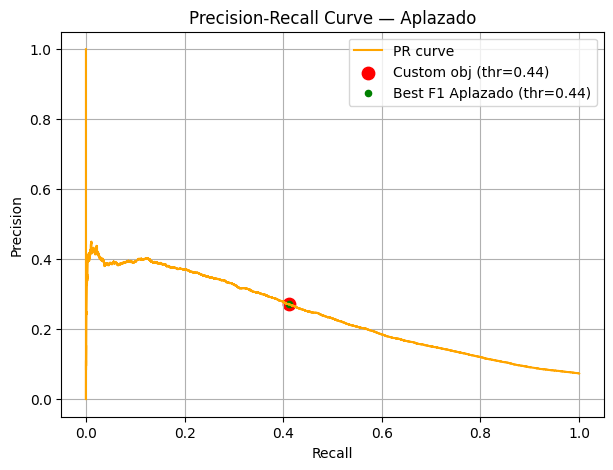

Resultados de optimización de threshold:
  - Custom objective: threshold=0.436, score=0.367
  - Best F1 Aplazado: threshold=0.436, f1=0.321


In [11]:
# 3. Optimizar threshold para la clase "Aplazado"
results = optimize_threshold_from_pr_with_plot(
    y_true=y_train_idx,
    probas=probas_cv,
    class_names=class_names,
    focus_class="Aplazado",
    alpha=0.8
)

best_thresholds_dict["precision_recall"] = results["thresholds"]

# 4. Mostrar resultados
print("Resultados de optimización de threshold:")
print(f"  - Custom objective: threshold={results['custom']['threshold']:.3f}, score={results['custom']['score']:.3f}")
print(f"  - Best F1 Aplazado: threshold={results['f1_focus']['threshold']:.3f}, f1={results['f1_focus']['f1']:.3f}")

----

**Reportar métricas**

1. Sin modificacion al umbral
2. Modificando el umbral:
   - Custom function
   - PR - Curve

In [12]:
best_thresholds_dict

{'funcion_objetivo': {'Abandono': np.float64(0.5),
  'Aplazado': np.float64(0.4878787878787879),
  'Matriculado': np.float64(0.5)},
 'roc': None,
 'precision_recall': {'Abandono': 0.5,
  'Aplazado': 0.4362273188422091,
  'Matriculado': 0.5}}

In [13]:
pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**Guardar Modelo**

In [14]:
import joblib

# Guardar el pipeline ya entrenado
joblib.dump(pipeline, f"pesos_modelo/pipeline_rf_{version_panel}.pkl")

# Guardar también el label encoder (si lo usaste para y)
joblib.dump(le, f"pesos_modelo/labelencoder_{version_panel}.pkl")

# Guardar thresholds (ej: los de precision_recall)
joblib.dump(best_thresholds_dict["precision_recall"], f"pesos_modelo/prob_thresholds_precisionRecall_{version_panel}.pkl")

['pesos_modelo/prob_thresholds_precisionRecall_panelV12.pkl']

### **Evaluación**

**1.Sin modificacion al umbral**

In [15]:
y_pred = pipeline.predict(X_test)
probas_test = pipeline.predict_proba(X_test)
print(f"\n\033[1m Test Balanced Accuracy Score:\033[0m {balanced_accuracy_score(y_test, y_pred):.2%}\n")
print(classification_report(y_test, y_pred, target_names=class_names, digits=3))


 Test Balanced Accuracy Score: 64.17%

              precision    recall  f1-score   support

    Abandono      0.339     0.633     0.441      1499
    Aplazado      0.269     0.441     0.334      1925
 Matriculado      0.955     0.851     0.900     23194

    accuracy                          0.809     26618
   macro avg      0.521     0.642     0.559     26618
weighted avg      0.871     0.809     0.833     26618



**2. Modificando el umbral - Custom Function**

In [16]:
y_pred_thr_of = utils_ml.predict_with_thresholds(probas_test, best_thresholds_dict['funcion_objetivo'], class_names)

print("\n\033[1m Test Balanced Accuracy (con thresholds optimizados segun funcion objetivo):\033[0m",
      f"{balanced_accuracy_score(y_test, y_pred_thr_of):.2%}\n")

print(classification_report(y_test, y_pred_thr_of, target_names=class_names, digits=3))


 Test Balanced Accuracy (con thresholds optimizados segun funcion objetivo): 64.17%

              precision    recall  f1-score   support

    Abandono      0.339     0.633     0.441      1499
    Aplazado      0.269     0.441     0.334      1925
 Matriculado      0.955     0.851     0.900     23194

    accuracy                          0.809     26618
   macro avg      0.521     0.642     0.559     26618
weighted avg      0.871     0.809     0.833     26618



**2.Modificando el umbral - Precision Recall Curve**

In [17]:
y_pred_thr_pr = utils_ml.predict_with_thresholds(probas_test, best_thresholds_dict['precision_recall'], class_names)

print("\n\033[1m Test Balanced Accuracy (con thresholds optimizados segun curva PR):\033[0m",
      f"{balanced_accuracy_score(y_test, y_pred_thr_pr):.2%}\n")

print(classification_report(y_test, y_pred_thr_pr, target_names=class_names, digits=3))


 Test Balanced Accuracy (con thresholds optimizados segun curva PR): 64.21%

              precision    recall  f1-score   support

    Abandono      0.341     0.622     0.440      1499
    Aplazado      0.265     0.457     0.335      1925
 Matriculado      0.956     0.847     0.898     23194

    accuracy                          0.806     26618
   macro avg      0.520     0.642     0.558     26618
weighted avg      0.871     0.806     0.832     26618



----

Observaciones Resultados:

- `custom function` vs `mecanismo estandar`: No presentan una variación importante los resultados. 
- `mecanismo estandar` vs `optimización via precision-recall`: Mejoró el balanced accuracy aunque no de manera considerable (~0.003), el recall de aplazamiento mejora 1.6% y la precisión empeora ~0.004. La precisión de Abandono sube ~0.002 y el recall baja 1.1%.  El f1- score incrementa ~0.001 para aplazados, empeora ~0.1% para abandono.

---

### **Reporte métricas de los resultados con los thresholds de Precision-Recall**

In [18]:
# --- Evaluación final en test ---
probas_test = pipeline.predict_proba(X_test)
# aplicar thresholds calibrados para obtener predicciones en test
y_pred_test = utils_ml.predict_with_thresholds(probas_test, best_thresholds_dict['precision_recall'], class_names)

print("Test - Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_test))
print("Test - F1 Macro:", f1_score(y_test, y_pred_test, average="macro"))
print("Test - F1 Aplazado:", f1_score(y_test, y_pred_test, labels=[class_names.index("Aplazado")], average="macro"))

Test - Balanced Accuracy: 0.6420513177574535
Test - F1 Macro: 0.5579126229576438
Test - F1 Aplazado: 0.3352402745995423


Proporciones de clases en el Train
0 → Abandono       0.059075
1 → Aplazado       0.073500
2 → Matriculado    0.867425
Name: proportion, dtype: float64

Proporciones de clases en el Test
0 → Abandono       0.056315
1 → Aplazado       0.072319
2 → Matriculado    0.871365
Name: proportion, dtype: float64




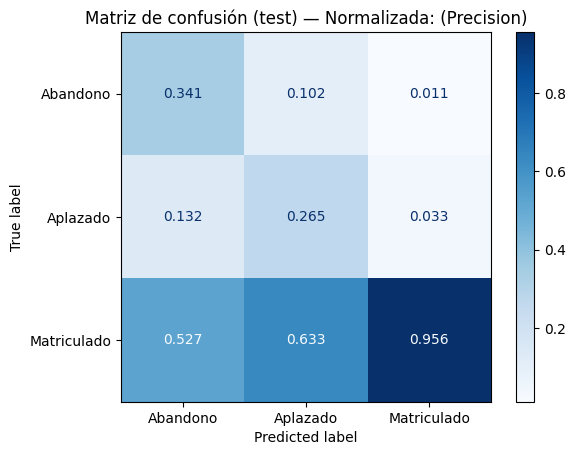

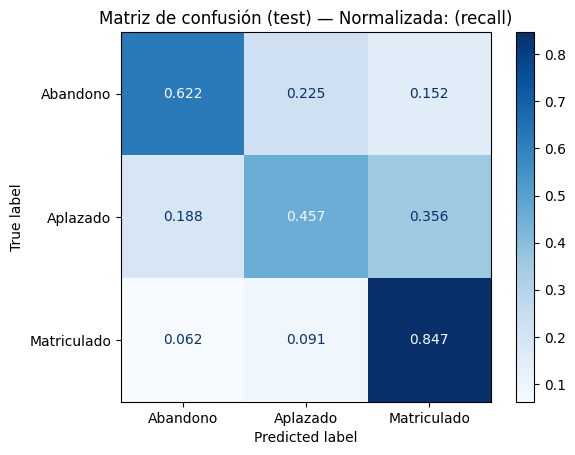

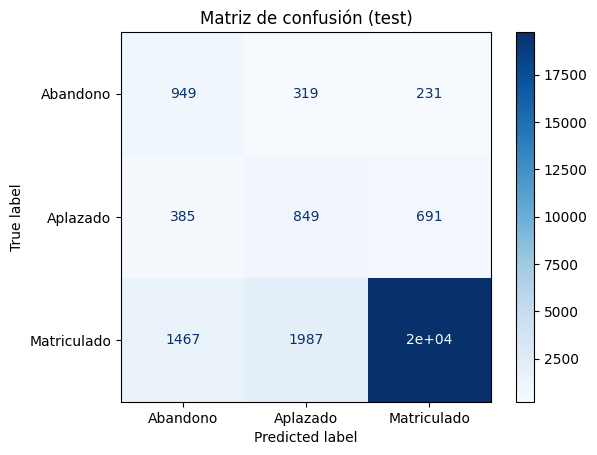

In [19]:
utils_ml.report_class_proportions(y, train_idx, test_idx,class_labels=le.classes_)
print("\n")
utils_ml.display_confusion_matrix(
    y_test,
    y_pred_thr_pr,
    le,
    normalize_parameter="pred",
    normalize_title = "Precision",
    savefig_path="output/precision_overall.pdf"
)
utils_ml.display_confusion_matrix(
    y_test,
    y_pred_thr_pr,
    le,
    normalize_parameter="true",
    normalize_title = "recall",
    savefig_path="output/recall_overall.pdf"
)
utils_ml.display_confusion_matrix(y_test,y_pred,le,normalize_parameter=None)

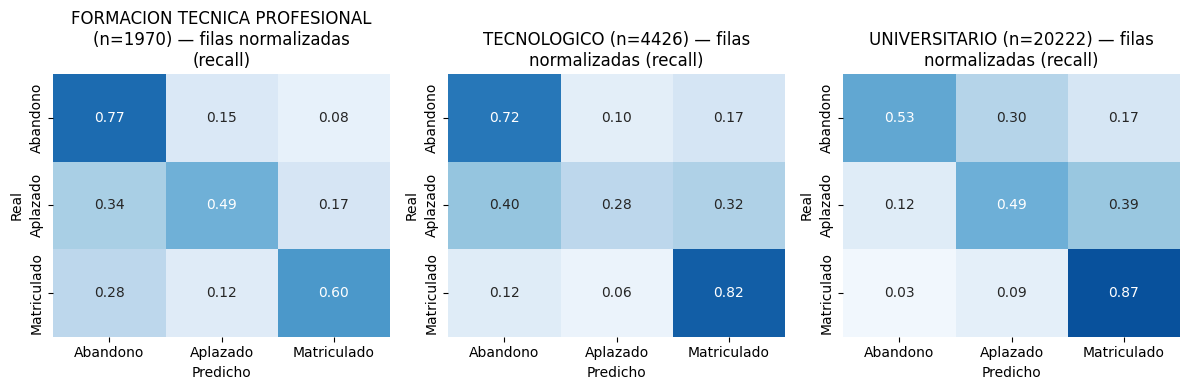

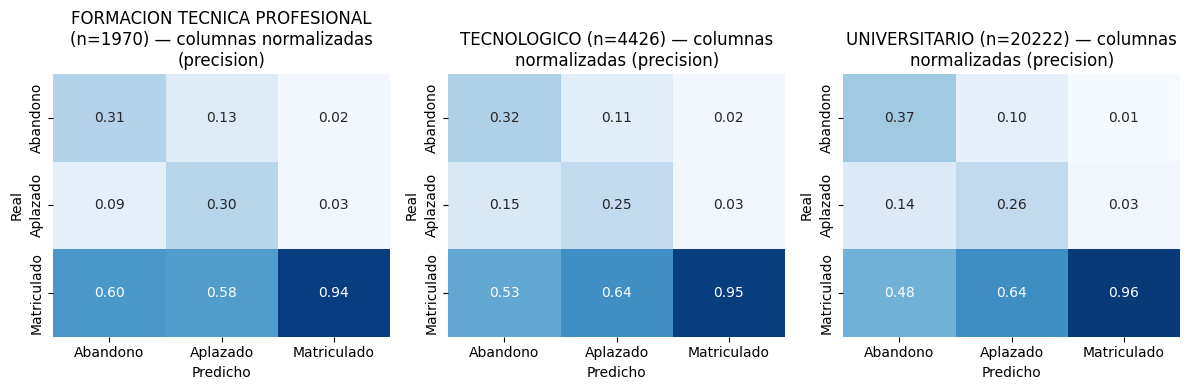

In [20]:
# 1) Obtener cms y métricas por semestre
cms, metrics_df, labels_idx = utils_ml.per_group_confusion_and_metrics(
    X_test, y_test, y_pred_thr_pr, group_col="NIVEL_FORMACION", label_encoder=le
)

utils_ml.plot_confusion_matrices_by_group(
    cms, 
    labels=le.classes_, 
    normalize_mode="recall", 
    savefig_path="output/recall_NIVEL_FORMACION.pdf"
)

utils_ml.plot_confusion_matrices_by_group(
    cms, 
    labels=le.classes_, 
    normalize_mode="precision", 
    savefig_path="output/precision_NIVEL_FORMACION.pdf"
)

          n  balanced_accuracy  f1_macro
group                                   
1      7595           0.656830  0.554077
2      6721           0.648152  0.567333
6       911           0.632253  0.570280
4      3454           0.630474  0.558108
3      5517           0.619294  0.547640
7       491           0.612600  0.586242
5      1929           0.578737  0.512019


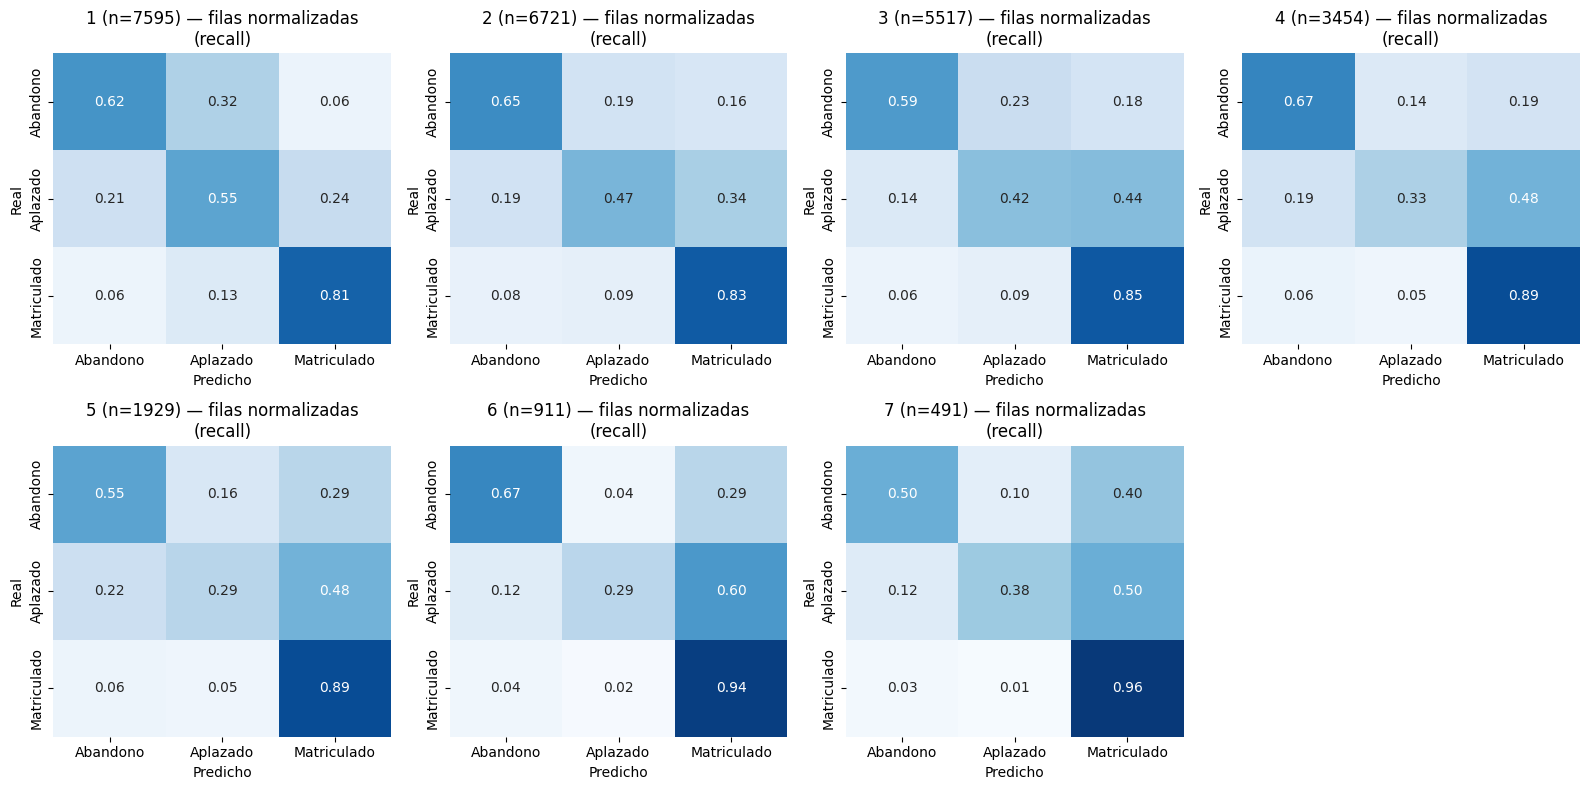

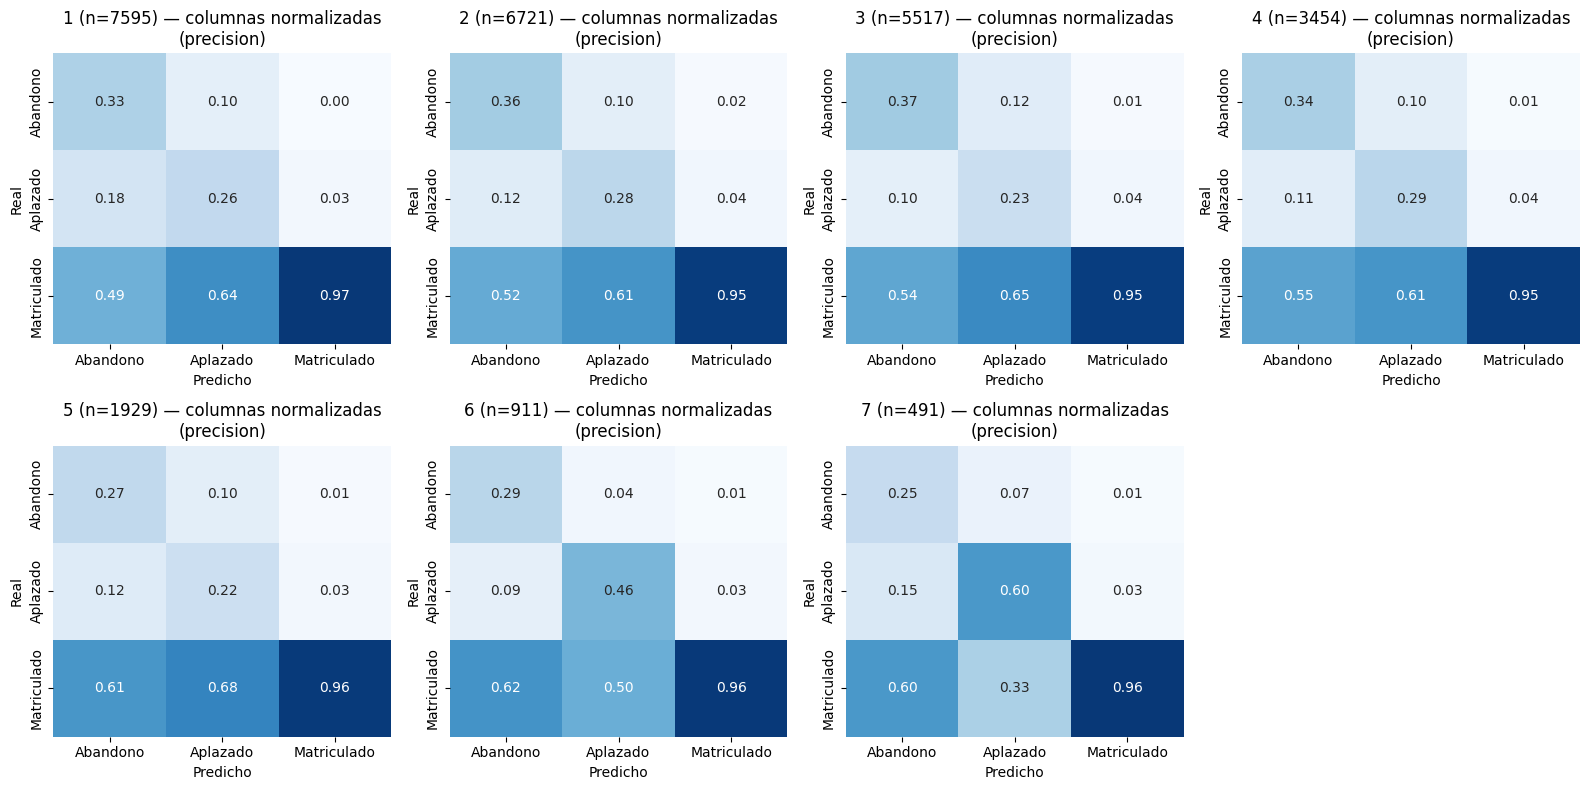


--- semestre: 1 (n=7595) ---
              precision    recall  f1-score   support

    Abandono       0.32      0.64      0.43       402
    Aplazado       0.27      0.52      0.35       664
 Matriculado       0.97      0.81      0.88      6529

    accuracy                           0.78      7595
   macro avg       0.52      0.66      0.55      7595
weighted avg       0.87      0.78      0.81      7595


--- semestre: 2 (n=6721) ---
              precision    recall  f1-score   support

    Abandono       0.36      0.65      0.46       465
    Aplazado       0.29      0.45      0.35       519
 Matriculado       0.95      0.84      0.89      5737

    accuracy                           0.79      6721
   macro avg       0.53      0.65      0.57      6721
weighted avg       0.86      0.79      0.82      6721


--- semestre: 3 (n=5517) ---
              precision    recall  f1-score   support

    Abandono       0.37      0.61      0.46       338
    Aplazado       0.24      0.42      

In [21]:
# 1) Obtener cms y métricas por semestre
cms, metrics_df, labels_idx = utils_ml.per_group_confusion_and_metrics(
    X_test, y_test, y_pred_thr_pr, group_col="semestre", label_encoder=le
)

# 2) Mostrar resumen tabular ordenado por n (soporte) o por balanced_accuracy
print(metrics_df.sort_values("balanced_accuracy", ascending=False))

# 3) Mostrar matrices de confusión por semestre (normalizadas por fila -> muestra recall por clase)
utils_ml.plot_confusion_matrices_by_group(
    cms, 
    labels=le.classes_, 
    normalize_mode="recall", 
    savefig_path="output/recall_por_semestre.pdf"
)

utils_ml.plot_confusion_matrices_by_group(
    cms, 
    labels=le.classes_, 
    normalize_mode="precision", 
    savefig_path="output/precision_por_semestre.pdf"
)
utils_ml.report_per_group(X_test, y_test, y_pred, group_col="semestre", label_encoder=le)

**Verificar que los indices de las matrices X y y estén alineados para asegurarse que las matrices de confusión están bien**

In [22]:
# Ejecuta el chequeo con tus objetos
utils_ml.check_alignment(X_train, X_test, y_train, y_test, y_pred=y_pred_thr_pr, grupos_train=grupos_train)

✅ Checks passed: X/y indices y longitudes están alineados para slicing posicional.


True

**Unificar resultados en un documento**

In [23]:
pdfs = [
    "output/recall_overall.pdf",
    "output/precision_overall.pdf",
    "output/recall_NIVEL_FORMACION.pdf",
    "output/precision_NIVEL_FORMACION.pdf",
    "output/recall_por_semestre.pdf",
    "output/precision_por_semestre.pdf"
]

utils.merge_pdfs(pdfs, f"output/evaluacion_rf_finetuned_{version_panel}.pdf")

✅ PDF combinado guardado en: output/evaluacion_rf_finetuned_panelV12.pdf
